Часть работы по ВКР:

**Исследование методов эффективного применения адаптеров (LoRA)  для дообучения моделей в условиях ограниченных вычислительных ресурсов**

- Загрузка Классификация на AG News
- EDA (размеры, классы, длины, графики)
- Подготовка токенизатора и модели Qwen2.5-1.5B
- Токенизация датасета
- Baseline-эксперимен:
  - загружается базовая модель Qwen2.5-1.5B
  - замораживаются все параметры, кроме классификационной головы
  - Trainer обучает 1 эпоху
  - собираются baseline-метрики
- LoRA эксперименты
  - Rank
    - 4
    - 8
    - 16
    - 32
  - Наборы модулей
    - ["q_proj", "v_proj"]
    - ["q_proj", "k_proj", "v_proj"]
    - ["q_proj", "k_proj", "v_proj", "o_proj"]

Для каждого запуска:
- обучение
- оценка
- замеры скорости
- замеры GPU-памяти

Финальная агрегация результатов:
- DataFrame df_results
- добавление baseline
- сохранение в lora_results.csv
- вывод сводной таблицы

In [1]:
!pip install transformers accelerate peft datasets evaluate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 10.3 MB/s eta 0:00:00


In [2]:
%pip -q install "transformers>=4.43" "datasets>=2.18" "accelerate>=0.33" "trl>=0.9" "bitsandbytes>=0.45"

import os, random, math, time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    DataCollatorForLanguageModeling
)

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

MODEL_NAME = "Qwen/Qwen2.5-1.5B"

DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
print("device:", device, "| dtype:", DTYPE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.8/528.8 kB 8.6 MB/s eta 0:00:00
False
device: cpu | dtype: torch.float16


In [7]:
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score
import evaluate

In [4]:
ds = load_dataset("ag_news")

label_map = ["World", "Sports", "Business", "Sci/Tech"]
num_labels = 4

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [5]:
train_ds = ds["train"]
test_ds = ds["test"]

print("Список колонок:")
print(ds.column_names)

print("\nРазмер датасета:")
print(ds.shape)

# Три случайных примера из train
print("\nТри случайных примера:")
import random

random_indices = random.sample(range(len(train_ds)), 3)

for idx in random_indices:
    example = train_ds[idx]
    print(f"\nПример {idx}:")
    print(f"Text: {example['text']}")
    print(f"Label: {example['label']}")

Список колонок:
{'train': ['text', 'label'], 'test': ['text', 'label']}

Размер датасета:
{'train': (120000, 2), 'test': (7600, 2)}

Три случайных примера:

Пример 83810:
Text: Policeman 'saw fatal train crash' An off-duty policeman watched a train plough into a car on a level crossing  in Berkshire, killing six people.
Label: 0

Пример 14592:
Text: Silver finale for USA In the last event of the 2004 Olympic Games, the United States track team produced one last surprise. Meb Keflezighi, a native of Eritrea who moved to the United States as 
Label: 1

Пример 3278:
Text: Compuware Blasts IBM #39;s Legal Tactics Two years ago, IBM was ordered to produce the source code for its products, which Compuware identified as containing its pirated intellectual property. The code was missing. But lo and behold -- last week, they called and said they had it, quot; ...
Label: 3


Train size: 120000
Test size:  7600

Columns: ['text', 'label']

Class distribution (train):
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Class distribution (test):
label
2    1900
3    1900
1    1900
0    1900
Name: count, dtype: int64

Average text length (train): 236.5 characters
Average text length (test):  235.3 characters
Text length range (train): 100 - 1012
Text length range (test):  100 - 892


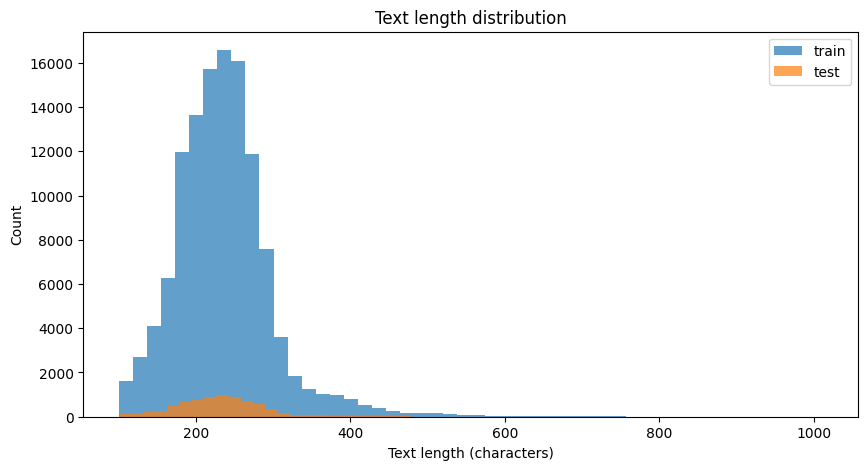

In [8]:
# Преобразуем в DataFrame для удобной статистики
df_train = pd.DataFrame(train_ds)
df_test  = pd.DataFrame(test_ds)

# Размеры датасета
print(f"Train size: {len(df_train)}")
print(f"Test size:  {len(df_test)}")

# Список колонок
print("\nColumns:", df_train.columns.tolist())

# Распределение классов
print("\nClass distribution (train):")
print(df_train['label'].value_counts())

print("\nClass distribution (test):")
print(df_test['label'].value_counts())

# Средняя длина текста
df_train['text_len'] = df_train['text'].apply(len)
df_test['text_len']  = df_test['text'].apply(len)

print(f"\nAverage text length (train): {df_train['text_len'].mean():.1f} characters")
print(f"Average text length (test):  {df_test['text_len'].mean():.1f} characters")

# Минимальная и максимальная длина текста
print(f"Text length range (train): {df_train['text_len'].min()} - {df_train['text_len'].max()}")
print(f"Text length range (test):  {df_test['text_len'].min()} - {df_test['text_len'].max()}")

# Визуализация распределения длины текста
plt.figure(figsize=(10,5))
plt.hist(df_train['text_len'], bins=50, alpha=0.7, label='train')
plt.hist(df_test['text_len'], bins=50, alpha=0.7, label='test')
plt.xlabel("Text length (characters)")
plt.ylabel("Count")
plt.title("Text length distribution")
plt.legend()
plt.show()

In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Добавляем pad_token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def load_base_model():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        torch_dtype=torch.float16,
        device_map="auto",
        ignore_mismatched_sizes=True
    )

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

In [ ]:
# Применяем токенизацию к датасету
train_tok = ds["train"].map(tokenize, batched=True)
test_tok = ds["test"].map(tokenize, batched=True)

# Преобразуем в формат PyTorch и удаляем ненужные колонки
train_tok = train_tok.remove_columns(["text"])
test_tok = test_tok.remove_columns(["text"])

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
train_tok

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 120000
})

In [ ]:
# Добавляем колонку с labels
if "label" in train_tok.column_names:
    train_tok = train_tok.rename_column("label", "labels")
    test_tok = test_tok.rename_column("label", "labels")

def create_lora_model(rank, target_modules):
    base = load_base_model()

    lora_cfg = LoraConfig(
        r=rank,
        lora_alpha=rank * 2,
        lora_dropout=0.05,
        target_modules=target_modules,
        task_type=TaskType.SEQ_CLS
    )
    return get_peft_model(base, lora_cfg)

def create_training_args(rank, target_modules, output_dir="./outputs"):
    name = f"r{rank}_" + "-".join(target_modules)

    return TrainingArguments(
        output_dir=f"{output_dir}/{name}",
        num_train_epochs=1,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        fp16=False,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="no",
        report_to="none",
        remove_unused_columns=False,
        dataloader_num_workers=4,
        # Добавляем метрики для мониторинга GPU
        logging_dir=f"{output_dir}/{name}/logs",
    )

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

def run_experiment(rank, target_modules, output_dir="./outputs"):
    # Создаем модель
    model = create_lora_model(rank, target_modules)
    print(f"Trainable parameters: {model.num_parameters(only_trainable=True):,}")

    # Создаем аргументы для тренировки
    args = create_training_args(rank, target_modules, output_dir)

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Мониторинг GPU до тренировки
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    start_time = time.time()

    # Тренировка
    trainer.train()

    # Оценка
    metrics = trainer.evaluate()

    end_time = time.time()

    # Сбор метрик GPU
    if torch.cuda.is_available():
        gpu_memory_allocated = torch.cuda.max_memory_allocated() / 1024**3  # в GB
        gpu_memory_reserved = torch.cuda.max_memory_reserved() / 1024**3    # в GB
    else:
        gpu_memory_allocated = 0
        gpu_memory_reserved = 0

    # Добавляем все метрики в результат
    metrics["time_sec"] = end_time - start_time
    metrics["rank"] = rank
    metrics["modules"] = "-".join(target_modules)
    metrics["gpu_memory_allocated_gb"] = gpu_memory_allocated
    metrics["gpu_memory_reserved_gb"] = gpu_memory_reserved
    metrics["trainable_parameters"] = model.num_parameters(only_trainable=True)

    # Очистка памяти
    del model
    del trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return metrics

In [ ]:
# Baseline: только classification head
print("\nЗапуск Baseline (только classification head)")
base_model = load_base_model()
# Замораживаем все слои кроме классификационной головы
for name, param in base_model.named_parameters():
    if "classifier" not in name and "score" not in name:
        param.requires_grad = False

print(f"Trainable parameters in baseline: {sum(p.numel() for p in base_model.parameters() if p.requires_grad):,}")


Запуск Baseline (только classification head)


`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Trainable parameters in baseline: 6,144


In [ ]:
args_baseline = TrainingArguments(
    output_dir="./outputs/baseline",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=False,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="no",
    report_to="none",
)

trainer_baseline = Trainer(
    model=base_model,
    args=args_baseline,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [ ]:
start_time = time.time()
trainer_baseline.train()
baseline_metrics = trainer_baseline.evaluate()
end_time = time.time()

baseline_metrics["time_sec"] = end_time - start_time
baseline_metrics["type"] = "baseline"
print(f"Baseline metrics: {baseline_metrics}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,143.512500,169.500000,0.622632,0.624894


Baseline metrics: {'eval_loss': 169.5, 'eval_accuracy': 0.6226315789473684, 'eval_f1': 0.6248936937642422, 'eval_runtime': 77.4661, 'eval_samples_per_second': 98.107, 'eval_steps_per_second': 24.527, 'epoch': 1.0, 'time_sec': 1420.9401369094849, 'type': 'baseline'}


In [ ]:
# LoRA эксперименты
ranks = [4, 8, 16, 32]
modules_list = [
    ["q_proj", "v_proj"],
    ["q_proj", "k_proj", "v_proj"],
    ["q_proj", "k_proj", "v_proj", "o_proj"]
]

results = []

for r in ranks:
    for m in modules_list:
        print(f"\n=== Запуск LoRA r={r}, modules={m} ===")
        try:
            metrics = run_experiment(r, m)
            results.append(metrics)
            print(f"Результаты: accuracy={metrics.get('eval_accuracy', 'N/A'):.4f}, "
                  f"f1={metrics.get('eval_f1', 'N/A'):.4f}, "
                  f"time={metrics['time_sec']:.2f}s, "
                  f"GPU memory={metrics['gpu_memory_allocated_gb']:.2f}GB")
        except Exception as e:
            print(f"Ошибка в эксперименте r={r}, modules={m}: {e}")
            continue


=== Запуск LoRA r=4, modules=['q_proj', 'v_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 550,912


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.663450,0.833984,0.930526,0.930478


Результаты: accuracy=0.9305, f1=0.9305, time=3516.18s, GPU memory=8.53GB

=== Запуск LoRA r=4, modules=['q_proj', 'k_proj', 'v_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 751,616


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.103319,1.190430,0.930658,0.930649


Результаты: accuracy=0.9307, f1=0.9306, time=3783.77s, GPU memory=8.73GB

=== Запуск LoRA r=4, modules=['q_proj', 'k_proj', 'v_proj', 'o_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 1,095,680


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.301263,0.282227,0.948553,0.948518


Результаты: accuracy=0.9486, f1=0.9485, time=4145.24s, GPU memory=8.95GB

=== Запуск LoRA r=8, modules=['q_proj', 'v_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 1,095,680


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.416093,0.436279,0.938026,0.937984


Результаты: accuracy=0.9380, f1=0.9380, time=3528.38s, GPU memory=8.54GB

=== Запуск LoRA r=8, modules=['q_proj', 'k_proj', 'v_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 1,497,088


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.549137,0.651855,0.935132,0.935076


Результаты: accuracy=0.9351, f1=0.9351, time=3786.73s, GPU memory=8.74GB

=== Запуск LoRA r=8, modules=['q_proj', 'k_proj', 'v_proj', 'o_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 2,185,216


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.287871,0.274902,0.948947,0.948930


Результаты: accuracy=0.9489, f1=0.9489, time=4143.37s, GPU memory=8.95GB

=== Запуск LoRA r=16, modules=['q_proj', 'v_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 2,185,216


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.260175,0.289062,0.944868,0.944810


Результаты: accuracy=0.9449, f1=0.9448, time=3544.47s, GPU memory=8.54GB

=== Запуск LoRA r=16, modules=['q_proj', 'k_proj', 'v_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 2,988,032


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.742908,0.819336,0.935789,0.935873


Результаты: accuracy=0.9358, f1=0.9359, time=3792.46s, GPU memory=8.75GB

=== Запуск LoRA r=16, modules=['q_proj', 'k_proj', 'v_proj', 'o_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 4,364,288


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.304863,0.265625,0.949868,0.949848


Результаты: accuracy=0.9499, f1=0.9498, time=4145.27s, GPU memory=8.98GB

=== Запуск LoRA r=32, modules=['q_proj', 'v_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 4,364,288


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.258857,0.287354,0.947105,0.947105


Результаты: accuracy=0.9471, f1=0.9471, time=3655.40s, GPU memory=8.55GB

=== Запуск LoRA r=32, modules=['q_proj', 'k_proj', 'v_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 5,969,920


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.688158,0.679688,0.940263,0.940312


Результаты: accuracy=0.9403, f1=0.9403, time=3934.66s, GPU memory=8.79GB

=== Запуск LoRA r=32, modules=['q_proj', 'k_proj', 'v_proj', 'o_proj'] ===


Loading weights:   0%|          | 0/338 [00:00<?, ?it/s]

Qwen2ForSequenceClassification LOAD REPORT from: Qwen/Qwen2.5-1.5B
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Trainable parameters: 8,722,432


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.310971,0.259033,0.950132,0.950141


Результаты: accuracy=0.9501, f1=0.9501, time=4335.90s, GPU memory=9.03GB


In [ ]:
# Создаем DataFrame со всеми результатами
df_results = pd.DataFrame(results)

# Добавляем baseline в результаты
baseline_row = pd.DataFrame([{
    'eval_accuracy': baseline_metrics.get('eval_accuracy', None),
    'eval_f1': baseline_metrics.get('eval_f1', None),
    'time_sec': baseline_metrics['time_sec'],
    'rank': 0,
    'modules': 'baseline',
    'type': 'baseline'
}])

df_results = pd.concat([baseline_row, df_results], ignore_index=True)

# Сохраняем результаты
df_results.to_csv("lora_results.csv", index=False)
print("\nРезультаты сохранены в lora_results.csv")
print(df_results)

# Выводим сводку
print("\nРезультаты")
print(df_results[['rank', 'modules', 'eval_accuracy', 'eval_f1', 'time_sec']].to_string())


Результаты сохранены в lora_results.csv
    eval_accuracy   eval_f1     time_sec  rank                      modules  \
0        0.622632  0.624894  1420.940137     0                     baseline   
1        0.930526  0.930478  3516.179150     4                q_proj-v_proj   
2        0.930658  0.930649  3783.772430     4         q_proj-k_proj-v_proj   
3        0.948553  0.948518  4145.242450     4  q_proj-k_proj-v_proj-o_proj   
4        0.938026  0.937984  3528.379654     8                q_proj-v_proj   
5        0.935132  0.935076  3786.726628     8         q_proj-k_proj-v_proj   
6        0.948947  0.948930  4143.366464     8  q_proj-k_proj-v_proj-o_proj   
7        0.944868  0.944810  3544.473177    16                q_proj-v_proj   
8        0.935789  0.935873  3792.459244    16         q_proj-k_proj-v_proj   
9        0.949868  0.949848  4145.269240    16  q_proj-k_proj-v_proj-o_proj   
10       0.947105  0.947105  3655.397848    32                q_proj-v_proj   
11       0.

**Основные выводы**

- LoRA позволяет существенно улучшить качество модели при минимальных вычислительных затратах.
- Наилучший прирост даёт увеличение набора целевых модулей (q,k,v,o), а не ранга.
- Ранг влияет меньше: модель выходит на плато уже при R=16.
- Наиболее рациональная конфигурация:
  - rank=8–16 + target_modules = [q_proj, k_proj, v_proj, o_proj]

- Увеличение ранга увеличивает время обучения, но не даёт существенного прироста качества.